# Clasificación de sargazo

Notebook inicial para clasificar el nivel de sargazon en imágenes de la playa. El notebook incuye varias redes neuronales profundas que se pueden usar preentrenadas o sin entrenamiento previo. Tu puedes dividir el conjunto de datos entre entrenamiento y validación. 

Si encuentras util el ćodigo te recomiendo que revises nuestro arítuclo científico que describe el problema.

https://www.mdpi.com/2076-3417/12/19/10012


In [15]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, transform
from PIL import Image
import os
import time
import copy

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms, utils
import torch.optim as optim
import sklearn
import sklearn.model_selection as skl
import seaborn as sn
%matplotlib inline
use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)
print("Torch version: ", torch.__version__)
print("Torchvision version: ", torchvision.__version__)
!python --version

cuda:0
Torch version:  2.1.2+cu121
Torchvision version:  0.16.2+cu121
Python 3.10.12


In [16]:
# Directorio de la carpeta donde esta el dataset
img_folder = 'images'
csv_file = 'labels/labels.csv'

# Hyper parameters
epochs = 50
current_epoch = 0
batch_size = 32
learning_rate = 0.00001
run_training = True #Si deseamos que el notebook ejecute el entrenamiento
model_name = 'vgg' # Red a cargar
pretrained = True # True indica que la red se va a inicializar con los parámetros entrenados
feature_extract = False #True indica que no se actualizan los parámetros
save_weights = True

wts_str = 'w_' + model_name + '_pret_' + str(pretrained) + '_feat_' + str(feature_extract) + '_lr_'+ str(learning_rate) 
print(wts_str)

w_vgg_pret_True_feat_False_lr_1e-05


## Objeto dataset

En PyTorch, un objeto Dataset se encarga de almacenar y manejar los datos que se usarán en modelos de aprendizaje automático. Es una clase abstracta de la cual se derivan clases específicas para manejar diferentes tipos de datos.  En este caso el objeto se implementa para leer de cada imagen su correspondiente etiqueta.

In [17]:
class SargazoDataset(Dataset):
    def __init__(self, dataframe, images_path, transform=None):
        """
        Args:
            txt_frame_file (string): Path to the txt files with labels.
            images_path (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.sargazo_frame = dataframe
        self.root_dir = images_path
        self.transform = transform
        self.class2id = test_count = {'nada': 0, 'bajo': 1, 'moderado': 2, 'abundante': 3, 'excesivo': 4}
        
    def pil_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')
    
    def __len__(self):
        return len(self.sargazo_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # cuidado si cambia la tabla se debe de cambiar esto
        image_path = os.path.join(self.root_dir, self.sargazo_frame.iloc[idx, 0])
        
        image = self.pil_loader(image_path)
        
        try: 
            label = self.sargazo_frame.iloc[idx, 3]
        except:
            label = 'unknown'

        if self.transform is not None:
            image = self.transform(image)
            
        sample = (image, self.class2id[label])

        return sample

## Dividir conjunto de datos

In [18]:
class2id = test_count = {'nada': 0, 'bajo': 1, 'moderado': 2, 'abundante': 3, 'excesivo': 4}
id2class = {0: 'nada', 1: 'bajo', 2: 'moderado', 3: 'abundante', 4: 'excesivo'}
num_classes = len(id2class)

full_dataset = pd.read_csv(csv_file) 
full_dataset.sample(5)

print(full_dataset.iloc[0, 4])

playa


In [19]:
col_labels = 'label'
random = 46 # for reproducible experiments

# Aqui se divide el conjunto de datos
train_df, valid_df = skl.train_test_split(full_dataset, test_size = 0.2, stratify = full_dataset[col_labels], random_state = random)

training_dataset = SargazoDataset(train_df, img_folder)
test_dataset = SargazoDataset(valid_df, img_folder)

print("Número de ejemplos:", len(training_dataset))

def show_image(image, label):
    plt.imshow(image, cmap = 'gray')
    plt.pause(0.001)  # pause a bit so that plots are updated

Número de ejemplos: 1780


## Mostrar unos ejemplos

(<PIL.Image.Image image mode=RGB size=960x720 at 0x743CF0D0B7C0>, 1)


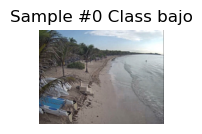

(<PIL.Image.Image image mode=RGB size=528x960 at 0x743CF0D0BF40>, 0)


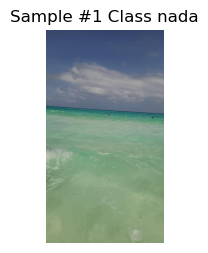

(<PIL.Image.Image image mode=RGB size=960x720 at 0x743CF0B69D20>, 0)


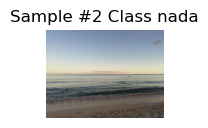

(<PIL.Image.Image image mode=RGB size=960x720 at 0x743CF0B7DC60>, 2)


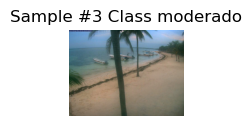

In [20]:
fig = plt.figure()

for i in range(len(training_dataset)):
    sample = training_dataset[i]
    print(sample)
    image, label = sample
    
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{} Class {}'.format(i, id2class[label]))
    ax.axis('off')
    show_image(image, label)

    if i == 3:
        plt.show()
        break

## Descenso por gradiente

Implementación del descenso por gradiente.

In [21]:
from torch.optim import lr_scheduler

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False, save_after=100, step_size=7, gamma=0.1):
    since = time.time()
    
    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Set up the learning rate scheduler
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'best_model.pt')
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            
            if phase == 'train' and epoch % save_after == 0:
                torch.save(model.state_dict(), 'model_epoch_{}.pt'.format(epoch))
        
        print()
        
        # Step the learning rate scheduler
        scheduler.step()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, val_loss_history, train_loss_history

In [22]:
# set model parameters
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            # Freeze parameters
            param.requires_grad = False

## Crear modelo de red neuronal

In [23]:
# Initialize and reshape the networks
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 512

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG16
        """
        model_ft = models.vgg19(pretrained=use_pretrained)
        #model_ft = models.vgg16(weights='IMAGENET1K_V1')
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=pretrained)

# Print the model we just instantiated
print(model_ft)

model_ft.to(device)

/home/rodrigo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rodrigo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## Entrenamiento

In [24]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [25]:
# configure paths to the description txt file and the images folder
#images_path = '../input/sargazo-dataset/sargazo_dataset/images'

# Create training and validation datasets
image_datasets = {'train': SargazoDataset(train_df, img_folder, data_transforms['train']), 'val': SargazoDataset(valid_df, img_folder, data_transforms['val'])}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

In [26]:
# create the optimizer
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn")

if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t", name)
            
optimizer_ft = optim.Adam(params_to_update, lr=learning_rate, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()

Params to learn
	 features.0.weight
	 features.0.bias
	 features.2.weight
	 features.2.bias
	 features.5.weight
	 features.5.bias
	 features.7.weight
	 features.7.bias
	 features.10.weight
	 features.10.bias
	 features.12.weight
	 features.12.bias
	 features.14.weight
	 features.14.bias
	 features.16.weight
	 features.16.bias
	 features.19.weight
	 features.19.bias
	 features.21.weight
	 features.21.bias
	 features.23.weight
	 features.23.bias
	 features.25.weight
	 features.25.bias
	 features.28.weight
	 features.28.bias
	 features.30.weight
	 features.30.bias
	 features.32.weight
	 features.32.bias
	 features.34.weight
	 features.34.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [27]:
#model_ft.load_state_dict(torch.load('best_model70.pth'))

In [28]:
# Execute full training
if run_training:
    model_ft, hist, hist_t,loss_hist,loss_hist_t = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs = epochs, is_inception=(model_name=="inception"))

Epoch 0/49
train Loss: 1.3304 Acc: 0.4365
val Loss: 1.2256 Acc: 0.4798

Epoch 1/49
train Loss: 1.1929 Acc: 0.4983
val Loss: 1.1636 Acc: 0.5538

Epoch 2/49
train Loss: 1.1125 Acc: 0.5326
val Loss: 1.0806 Acc: 0.5605

Epoch 3/49
train Loss: 1.0463 Acc: 0.5770
val Loss: 1.0341 Acc: 0.5785

Epoch 4/49
train Loss: 1.0185 Acc: 0.5949
val Loss: 1.0351 Acc: 0.5987

Epoch 5/49
train Loss: 0.9756 Acc: 0.6051
val Loss: 0.9306 Acc: 0.6256

Epoch 6/49
train Loss: 0.9272 Acc: 0.6247
val Loss: 0.9244 Acc: 0.6390

Epoch 7/49
train Loss: 0.8967 Acc: 0.6371
val Loss: 0.9077 Acc: 0.6323

Epoch 8/49
train Loss: 0.8806 Acc: 0.6489
val Loss: 0.9043 Acc: 0.6390

Epoch 9/49
train Loss: 0.8800 Acc: 0.6483
val Loss: 0.9035 Acc: 0.6502

Epoch 10/49
train Loss: 0.8700 Acc: 0.6483
val Loss: 0.8992 Acc: 0.6368

Epoch 11/49
train Loss: 0.8629 Acc: 0.6500
val Loss: 0.8960 Acc: 0.6390

Epoch 12/49
train Loss: 0.8653 Acc: 0.6545
val Loss: 0.8935 Acc: 0.6457

Epoch 13/49
train Loss: 0.8768 Acc: 0.6506
val Loss: 0.8962 A

In [ ]:
if save_weights:
    torch.save(model_ft.state_dict(), wts_str)

## Graficar resultados

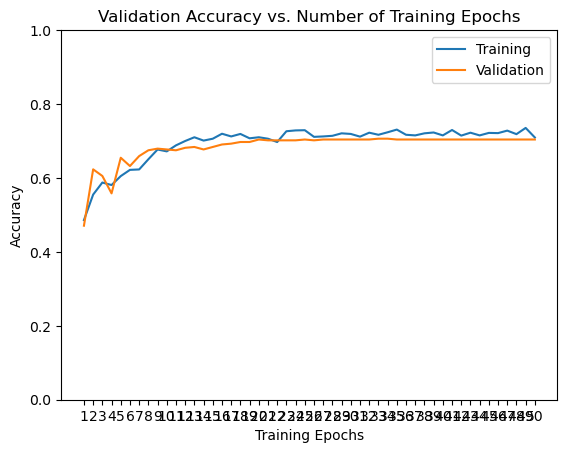

In [ ]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
vhist = []
thist = []

vhist = [h.cpu().numpy() for h in hist]
thist = [h.cpu().numpy() for h in hist_t]
#shist = [h.cpu().numpy() for h in scratch_hist]

np.save('val_history', vhist)
np.save('train_history', vhist)

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,epochs+1),thist,label="Training")
plt.plot(range(1,epochs+1),vhist,label="Validation")
plt.ylim((0,1.))
plt.xticks(np.arange(1, epochs+1, 1.0))
plt.legend()
file_name = wts_str + '_acc.png'
plt.savefig(file_name)
plt.show()

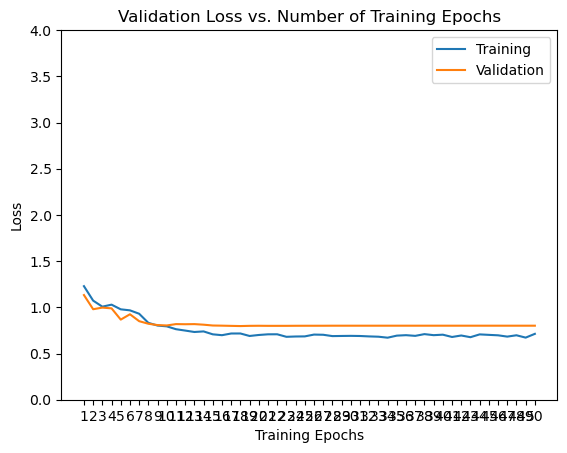

In [ ]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
vhist_loss = np.array(loss_hist)
thist_loss = np.array(loss_hist_t)

np.save('val_history', vhist_loss)
np.save('train_history', thist_loss)

plt.title("Validation Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1,epochs+1),thist_loss,label="Training")
plt.plot(range(1,epochs+1),vhist_loss,label="Validation")
plt.ylim((0,4.))
plt.xticks(np.arange(1, epochs+1, 1.0))
plt.legend()
file_name = wts_str + '_loss.png'
plt.savefig(file_name)
plt.show()

In [ ]:
def test_model(model, dataloaders):
    print("Evaluating model")
    print(time.time())
            
    # Iterate over data
    it = 0
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
                
        model.train(False)
        model.eval()
                    
        outputs = model(inputs)
                        
        _, preds = torch.max(outputs, 1)
        
        np_pred_labels = preds.cpu().numpy()
        np_real_labels = labels.cpu().numpy()
        if it == 0:
            pred_labels = np_pred_labels
            real_labels = np_real_labels
        else:
            pred_labels = np.concatenate((pred_labels,np_pred_labels))
            real_labels = np.concatenate((real_labels,np_real_labels))
        it= it+1
        
        del inputs
        del labels
        torch.cuda.empty_cache()
    
    print(time.time())
    return pred_labels,real_labels

In [ ]:
predict_labels,actual_labels = test_model(model_ft, dataloaders_dict)

Evaluating model
1719772020.595125
1719772023.5149267


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(actual_labels,predict_labels))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       209
           1       0.63      0.64      0.63       133
           2       0.54      0.32      0.40        47
           3       0.25      0.10      0.14        21
           4       0.62      0.83      0.71        36

    accuracy                           0.71       446
   macro avg       0.57      0.55      0.55       446
weighted avg       0.68      0.71      0.69       446



In [ ]:
df_confusion = pd.crosstab(actual_labels, predict_labels,rownames=["True label"],colnames=["Predicted label"])
print(df_confusion)
df_confusion.rename(columns=id2class,index=id2class,inplace=True)
print(df_confusion)
df_confusion.to_csv('cm_exp5.csv')

Predicted label    0   1   2  3   4
True label                         
0                183  23   0  1   2
1                 37  85   8  0   3
2                  4  18  15  4   6
3                  1   7   4  2   7
4                  2   2   1  1  30
Predicted label  nada  bajo  moderado  abundante  excesivo
True label                                                
nada              183    23         0          1         2
bajo               37    85         8          0         3
moderado            4    18        15          4         6
abundante           1     7         4          2         7
excesivo            2     2         1          1        30


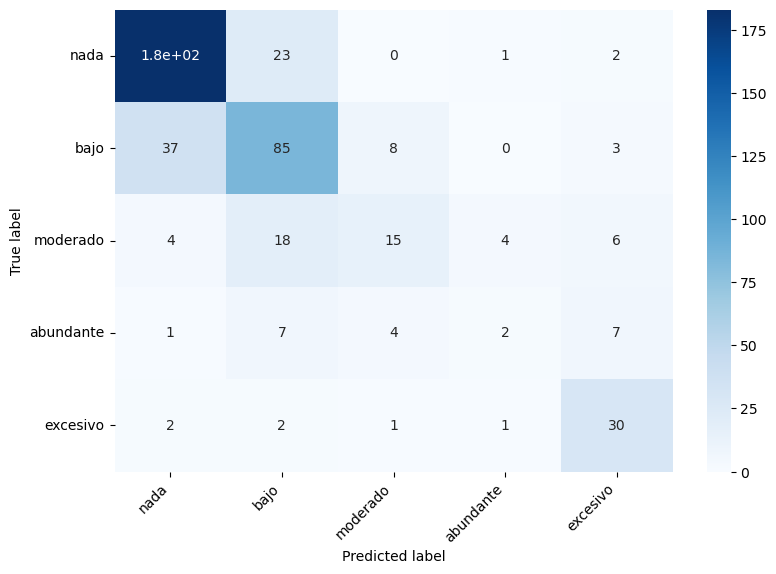

In [ ]:
f, ax = plt.subplots(figsize=(9,6))

parameters = {'axes.labelsize': 10}
plt.rcParams.update(parameters)

g = sn.heatmap(df_confusion, annot = True, cmap = 'Blues',ax=ax)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_yticklabels(g.get_yticklabels(), rotation=0, horizontalalignment='right')

plt.savefig("CM_exp5.eps",format = "eps",bbox_inches='tight')
plt.show()

In [ ]:
df_norm_col= round(df_confusion.div(df_confusion.sum(axis=1),axis=0),2) 
print(df_norm_col)

Predicted label  nada  bajo  moderado  abundante  excesivo
True label                                                
nada             0.88  0.11      0.00       0.00      0.01
bajo             0.28  0.64      0.06       0.00      0.02
moderado         0.09  0.38      0.32       0.09      0.13
abundante        0.05  0.33      0.19       0.10      0.33
excesivo         0.06  0.06      0.03       0.03      0.83


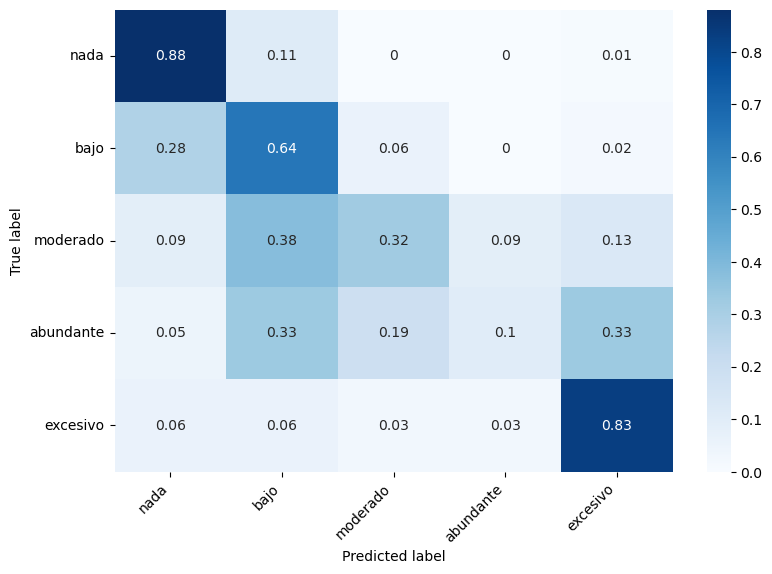

In [ ]:
f, ax = plt.subplots(figsize=(9,6))

parameters = {'axes.labelsize': 10}
plt.rcParams.update(parameters)

g = sn.heatmap(df_norm_col, annot = True, cmap = 'Blues')
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_yticklabels(g.get_yticklabels(), rotation=0, horizontalalignment='right')

plt.savefig("CM_exp5_norm.eps",format = "eps",bbox_inches='tight')
plt.show()

## Inferencia para el challenge

In [ ]:
test_file = 'labels/test.csv'

In [ ]:
test_df = pd.read_csv(test_file) 
test_df.sample(5)


,image_name,place,date
113,s0966.jpg,Punta Cancun,7/19/2019
45,s0886.jpg,Akumal,9/23/2019
111,s0964.jpg,Tulum,6/20/2019
37,s0878.jpg,Playa del Carmen,8/1/2019
84,s0929.jpg,Cancun,2/19/2019


In [ ]:
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

    
model_ft.eval()
test_predictions = []
for file in test_df['image_name']:
    
    # cuidado si cambia la tabla se debe de cambiar esto
    image_path = os.path.join(img_folder, file)
    #print(image_path)
    
    image = pil_loader(image_path)
    img_transf = data_transforms['val'](image)
    img_transf = img_transf.unsqueeze(0)
    #print(img_transf.shape)
    
    #print(labels)
    img_transf = img_transf.to(device)
                       
    outputs = model_ft(img_transf)
    #print(outputs)                    
    _, preds = torch.max(outputs, 1)
    test_predictions.append(id2class[preds.cpu().numpy()[0]])
    
#print(test_predictions)
temp = {'image_name': test_df['image_name'], 'label': test_predictions}
output_df = pd.DataFrame(data=temp)
output_df.sample(10)

output_df.to_csv('outputs.csv')